# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np
import pandas as pd

# Librerias para graficar
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
# Modulo de optimización de scipy
from scipy import optimize


# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [3]:
# Cargar datos
# Las dos primeras columnas contienen la nota de dos examenes y la tercera columna
# contiene la etiqueta que indica si el alumno ingreso o no a la universidad.
data = pd.read_csv('/content/drive/MyDrive/SIS420/MiDataSets/CreditCardData.csv')
data.info()
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14  Bank                 

In [4]:
#Eliminamos el Simbolo de libra Esterlina para no tener problemas
columnas_eliminar = ['Amount']
simbolo = '£'

for columna in columnas_eliminar:
    data[columna] = data[columna].str.replace(simbolo, '', regex=False)

In [5]:
#print(data)

In [6]:
# Eliminamos la columna de IDs
columna_categorica = 'Transaction ID'

# Eliminamos la columna
data.drop(columna_categorica, axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Date                    100000 non-null  object 
 1   Day of Week             100000 non-null  object 
 2   Time                    100000 non-null  int64  
 3   Type of Card            100000 non-null  object 
 4   Entry Mode              100000 non-null  object 
 5   Amount                  99994 non-null   object 
 6   Type of Transaction     100000 non-null  object 
 7   Merchant Group          99990 non-null   object 
 8   Country of Transaction  100000 non-null  object 
 9   Shipping Address        99995 non-null   object 
 10  Country of Residence    100000 non-null  object 
 11  Gender                  99996 non-null   object 
 12  Age                     100000 non-null  float64
 13  Bank                    100000 non-null  object 
 14  Fraud                

In [7]:
#variables categoricas
columnas_categoricas = data.select_dtypes(include=['object']).columns
#Procesamiento de frases o palabras
for columna in columnas_categoricas:
  le = LabelEncoder()
  data[columna] = le.fit_transform(data[columna])

In [8]:
#print(data)
#data.info()


In [9]:
#Separamos 80% para entrenar el dataset y 20% para pruebas
X_train = data.iloc[:80000,0 :14].values  # Todas las filas, desde la columna 9 hasta la penúltima
y_train = data.iloc[:80000, 14].values    # Todas las filas, última columna
X_test = data.iloc[80001:, 0:14].values  # Filas desde la 48000 hasta el final, desde la columna 9 hasta la penúltima
y_test = data.iloc[80001:, 14].values    # Filas desde la 48000 hasta el final, última columna
#print(X_train)
#print(X_test)
X=X_train
y=y_train

In [10]:
#vemos los valores
print(X)
print(y)

[[ 1.   3.  19.  ...  1.  25.2  7. ]
 [ 1.   3.  17.  ...  0.  49.6  4. ]
 [ 1.   3.  14.  ...  0.  42.2  0. ]
 ...
 [ 0.   2.  13.  ...  1.  44.   5. ]
 [ 1.   3.   9.  ...  1.  36.8  3. ]
 [ 1.   3.  15.  ...  0.  57.8  3. ]]
[0 0 0 ... 0 0 0]


In [11]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)

    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

In [12]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [13]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [14]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [15]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

theta calculado por el descenso por el gradiente: [ 0.00879188 -0.00132509  0.01588439 -0.18938641  0.02121076 -0.00360762
  0.00176944  0.03024772 -0.07012668 -0.2733181  -0.28386796  0.21488491
  0.0297432   0.01936224  0.00637307]


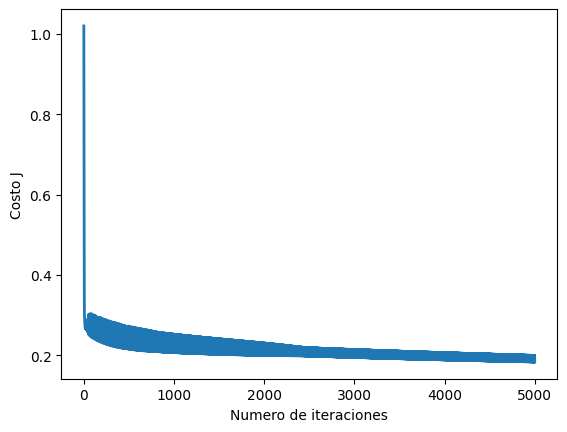

In [16]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001
num_iters = 5000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(15)
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

In [17]:
print(X_test)
print(y_test)

[[ 1.   3.   7.  ...  1.  54.3  0. ]
 [ 1.   3.   7.  ...  0.  41.4  0. ]
 [ 0.   2.  17.  ...  0.  40.8  6. ]
 ...
 [ 0.   2.  11.  ...  0.  46.5  2. ]
 [ 1.   3.  22.  ...  1.  48.2  0. ]
 [ 1.   3.  16.  ...  1.  31.7  6. ]]
[0 0 0 ... 0 0 0]


In [18]:
#normalizamos X_test
X_test_norm, mu, sigma = featureNormalize(X_test)
m, n = X_test_norm.shape
X_test_norm = np.concatenate([np.ones((m, 1)), X_test_norm], axis=1)


In [19]:
#Visualizamos el valor de y en en la posicion que deseamos
print(y_test[36])

0


In [25]:
#Predecimos si hubo fraude o no
prediccion = sigmoid(np.dot(X_test_norm[36], theta))   # Se debe cambiar esto
print('La probabilidad de que haya fraude es de: {:s}'.format(str(prediccion)))

La probabilidad de que haya fraude es de: 0.3574884635391456
